# Prediction of used car prices -  challenge to handle and model real life data

____

### Project objective
The objective of the project is to get the best possible used car price prediction in accordance to a set of available dimensions and metrics with use of ML methods that I have learned from the Data Science extramural Bootcamp. 

The data for the project is a real world used car ads records originated from Kaggle (https://www.kaggle.com/mirosval/personal-cars-classifieds). The data was scraped by Miroslav Zoricak from several websites in Czech Republic and Germany over a period of more than a year within late 2015 and early 2017.

The original dataframe includes the following columns:
- <b>maker</b>- normalized all lowercase
- <b>model</b> - normalized all lowercase
- <b>mileage</b> - in KM
- <b>manufacture_year</b>
- <b>engine_displacement</b> - in ccm
- <b>engine_power</b> - in kW (converted in data prep to HP)
- <b>body_type</b> - almost never present, but I scraped only personal cars, no motorcycles or utility vehicles
- <b>color_slug</b> - also almost never present
- <b>stk_year</b> - year of the last emission control
- <b>transmission</b> - automatic or manual
- <b>door_count</b>
- <b>seat_count</b>
- <b>uel_type</b> - gasoline, diesel, cng, lpg, electric
- <b>date_created</b> - when the ad was scraped
- <b>datelastseen</b> - when the ad was last seen. Our policy was to remove all ads older than 60 days
- <b>price_eur</b> - list price converted to EUR


The autor of the data claims that data scraped can not provide accurate predictions due to data quality issues, ie. missing values, variance, and presence of outliers. Having this noted, thorough data cleansing is one of the major project challanges. The possible outcome can bring up significant data reduction, but should increase accuracy of predictions.

It is also important to remark that data provided does not contain such important information as condition of a car, how it is equipped, or possible bumbs in a history of a car. They are all crucial to better set up and predict the price for the model.  

Despite this leakage I will attempt to reach best possible R2 score in general and check out how the price predictions perform across most popular ML models.

Since the raw data is very extensive in volume (it contains over 3,5 million records) I will limit it by sampling 50 000 of the used car examples. 

*******

# Getting and limiting the raw file

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

random_seed=42

# switch off future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [250]:
df = pd.read_csv('./cars.csv', sep=',', low_memory=False)
df.head(5)

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


The original dataset is quite extensive in volume:

In [251]:
len(df)

3552912

Checking out when cars were scraped:

In [252]:
import datetime as dt

df['year'] = pd.to_datetime(df['date_created']).dt.year
df['month'] = pd.to_datetime(df['date_created']).dt.month.map("{:02}".format)

df['created_year_month']= df[['year', 'month']].astype(str).agg('_'.join, axis=1)

df.sort_values(by='created_year_month', inplace=True)

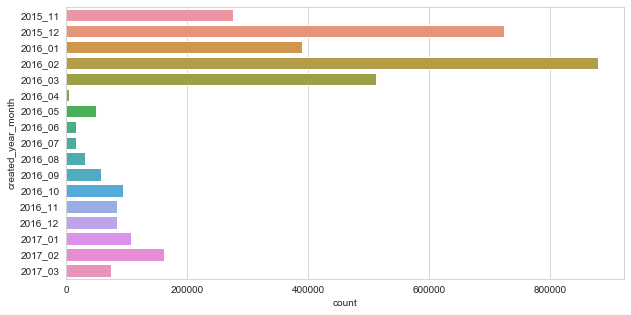

In [253]:
plt.figure(figsize=(10,5))
sns.countplot(y=df['created_year_month'])
plt.show()

As we can see above, the volumes of car ads per month vary, especially across March and Aprill 2016. This is presumably because scrapping method had been tuned up in that time. I decided to shorten the scraping timeframe window, as this should provide more coherent data and improve overall prediction accuracy.

In [254]:
df.groupby(['created_year_month'])['price_eur'].describe()

,count,mean,std,min,25%,50%,75%,max
created_year_month,,,,,,,,
2015_11,274925.0,1.233104e+04,3.697931e+05,0.04,1490.2300,5366.40,13404.00,1.000148e+08
2015_12,724271.0,2.202072e+04,7.204187e+05,0.04,3951.4800,10078.98,18010.66,3.404523e+08
2016_01,389107.0,1.813875e+04,4.169198e+05,370.10,4001.5200,10408.40,18866.69,1.000074e+08
2016_02,879196.0,6.528335e+06,4.071998e+09,370.10,5657.0825,11950.00,19990.00,2.706149e+12
2016_03,511399.0,1.644282e+04,2.899182e+05,370.10,4996.8200,11499.00,19790.00,1.001332e+08
2016_04,4297.0,1.439998e+04,3.580285e+04,370.10,2849.7400,6846.78,14208.29,5.464202e+05
2016_05,48869.0,1.126372e+04,1.914449e+04,370.10,2900.1100,7134.27,14803.81,1.715063e+06
2016_06,15497.0,7.837597e+03,9.455459e+03,370.10,2775.7200,5514.43,9992.56,2.960400e+05
2016_07,15898.0,7.467093e+03,8.804289e+03,370.10,2775.7200,5181.31,9215.40,2.331606e+05


The scraped period will get limited to January 2016 - March 2016, as further scrapings do not show variance in the predicted variable (price_eur).

In [255]:
df = df[df['created_year_month'].between('2016_01','2016_03')]
df.to_csv('.\Cars_Jan_Mar_2016.csv')

******************************


# Data preparation

In [256]:
df = pd.read_csv('./Cars_Jan_Mar_2016.csv', sep=',', low_memory=False, index_col=[0])

In [257]:
df.head()

,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur,year,month,created_year_month
1258599,hyundai,i10,44373.0,2011.0,1086.0,49.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.351263+00,2016-07-03 18:07:57.593938+00,5900.22,2016,1,2016_01
1258590,fiat,NaN,149000.0,2000.0,1900.0,NaN,NaN,NaN,None,man,4,None,diesel,2016-01-15 23:48:00.139562+00,2016-01-20 09:03:13.640667+00,1999.07,2016,1,2016_01
1258602,audi,a1,79850.0,2011.0,1390.0,90.0,NaN,NaN,None,auto,2,4,gasoline,2016-01-15 23:48:18.44457+00,2016-07-03 18:08:03.813917+00,11990.45,2016,1,2016_01
1258603,hyundai,i10,25.0,2016.0,998.0,49.0,NaN,NaN,None,auto,4,5,gasoline,2016-01-15 23:48:18.473834+00,2016-07-03 18:08:18.223965+00,9235.34,2016,1,2016_01
1258600,hyundai,i20,50785.0,2012.0,1248.0,63.0,NaN,NaN,None,man,4,5,gasoline,2016-01-15 23:48:18.38062+00,2016-07-03 18:08:02.791752+00,8450.30,2016,1,2016_01


In [258]:
raw_len = len(df)
print(raw_len)

1779702


In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779702 entries, 1258599 to 2437959
Data columns (total 19 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
year                   int64
month                  int64
created_year_month     object
dtypes: float64(5), int64(2), object(12)
memory usage: 271.6+ MB


In [260]:
df.columns

Index(['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement',
       'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission',
       'door_count', 'seat_count', 'fuel_type', 'date_created',
       'date_last_seen', 'price_eur', 'year', 'month', 'created_year_month'],
      dtype='object')

Converting engine_power from kW to HP units.

In [261]:
df['engine_power'] = 1.3410220888*df['engine_power']

Calculating the age of a car, when the ad was scraped, instead of the manufacturing_year.
Removing unnecessary column.

In [262]:
df['age_years'] = (df['year']-df['manufacture_year'])
df.drop(columns=['manufacture_year', 'year', 'month'], inplace=True)

Checking out the % share of null values across variables

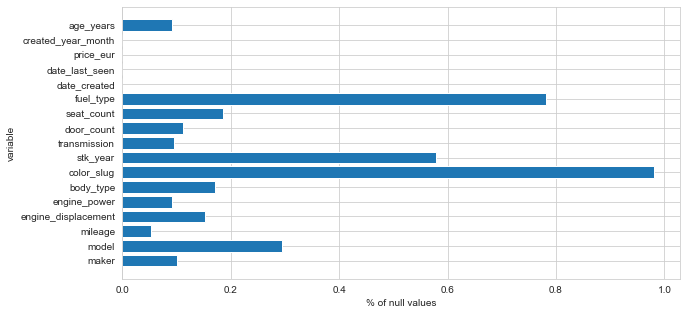

In [263]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

It seems that a number of variables have lot of missing values:

date_last_seen  - does not bring any useful information (as the policy was to remove all ads that had not been seen more than 60 days before scraping).

stk_year, color_slug  - variables that definitely need to be removed from the dataset, because of missing values

In [264]:
df.drop(columns=['stk_year', 'color_slug', 'date_last_seen'], inplace=True)

Checking out fuel type as it is not present in most cases

In [265]:
df['fuel_type'].value_counts()

gasoline    205837
diesel      183270
Name: fuel_type, dtype: int64

fuel_type should be important to predict the price but stands out in terms of missing values.
However, it can not be easily imputed, since the same engine capacities can ran with different fuel. Therefore I also decided to drop the variable. I will not be helpful in accordance to new car records.

In [266]:
df.drop(columns='fuel_type', inplace=True)

If no maker, model or manufacture_year is present in the dataset, we can not say if the price prediction is correct. These cases will also get dropped.

In [267]:
df.dropna(subset=['maker', 'model', 'age_years'], inplace=True)

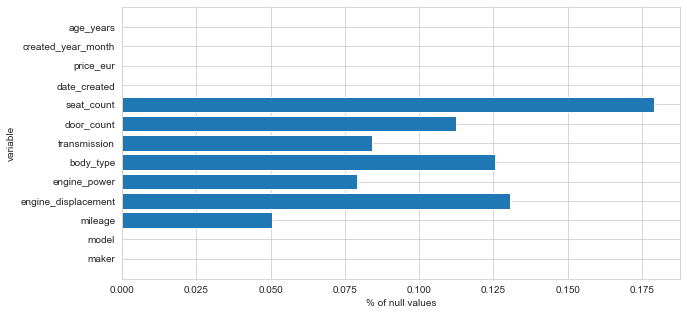

In [268]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

In [269]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1258599,hyundai,i10,44373.0,1086.0,65.710082,NaN,man,4,5,2016-01-15 23:48:18.351263+00,5900.22,2016_01,5.0
1258602,audi,a1,79850.0,1390.0,120.691988,NaN,auto,2,4,2016-01-15 23:48:18.44457+00,11990.45,2016_01,5.0
1258603,hyundai,i10,25.0,998.0,65.710082,NaN,auto,4,5,2016-01-15 23:48:18.473834+00,9235.34,2016_01,0.0
1258600,hyundai,i20,50785.0,1248.0,84.484392,NaN,man,4,5,2016-01-15 23:48:18.38062+00,8450.30,2016_01,4.0
1258601,hyundai,santa-fe,14487.0,2199.0,194.448203,NaN,auto,4,5,2016-01-15 23:48:18.410752+00,27901.04,2016_01,4.0


## Filtering out the outlier values

The variables present alot of variance. Some values are out of the reasonable range. See the table below.

In [270]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.081564e+06,990232.000000,1.048723e+06,1.138866e+06,1.138866e+06
mean,9.902788e+04,1814.424140,1.232749e+02,6.879184e+04,8.826922e+00
std,2.633064e+05,1342.416534,5.987303e+01,2.795810e+07,4.388576e+01
min,0.000000e+00,1.000000,2.682044e+00,3.701000e+02,0.000000e+00
25%,2.150000e+04,1389.000000,8.850746e+01,4.600000e+03,2.000000e+00
50%,7.679950e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.385000e+05,1968.000000,1.408073e+02,1.697000e+04,1.000000e+01
max,9.999999e+06,32000.000000,2.016897e+03,1.492235e+10,2.016000e+03


The dataset obiously shows outliers. I decided to trim 0.5 percentile values on each edge of a variable.
The outliers will be set as with np.nan values and imputed in fursher step.

In [271]:
for i in df.describe().columns:
    df[i] = np.where(df[i].between(df[i].quantile(q=0.005), df[i].quantile(q=0.995)), df[i], np.nan)

In [272]:
df.describe()

,mileage,engine_displacement,engine_power,price_eur,age_years
count,1.076156e+06,980509.000000,1.039204e+06,1.127484e+06,1.133362e+06
mean,8.757411e+04,1746.097122,1.216716e+02,1.239726e+04,6.744254e+00
std,7.429605e+04,607.581520,5.250845e+01,1.070496e+04,5.721709e+00
min,0.000000e+00,800.000000,4.961782e+01,5.181300e+02,0.000000e+00
25%,2.128600e+04,1390.000000,8.850746e+01,4.663210e+03,2.000000e+00
50%,7.600000e+04,1598.000000,1.086228e+02,9.980000e+03,5.000000e+00
75%,1.372500e+05,1968.000000,1.408073e+02,1.690000e+04,1.000000e+01
max,3.723460e+05,6800.000000,4.237630e+02,8.032500e+04,4.500000e+01


We will nextattempt to drop outliers for door_count and seat_count, as both variables ar strings.

In [273]:
df[['door_count', 'seat_count']] = df[['door_count', 'seat_count']].replace('None', np.nan).apply(pd.to_numeric)

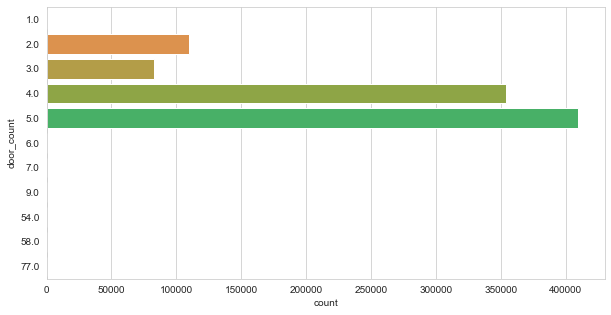

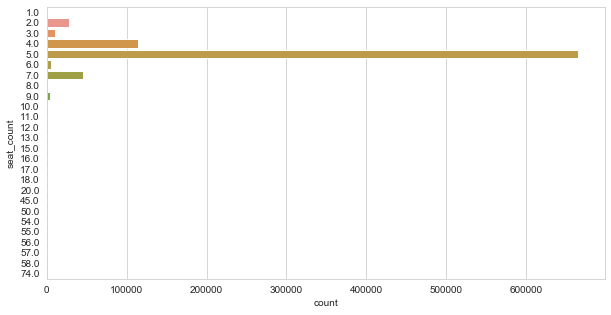

In [274]:
for i in ['door_count', 'seat_count']:
    plt.figure(figsize=(10,5))
    sns.countplot(y=df[i])
    plt.show()

Drop cars with atypical door_number, since data scraped should include regular cars only.

In [275]:
df = df[df['door_count'].between(2,5)]

## Imputing missing values with means and mode for groups

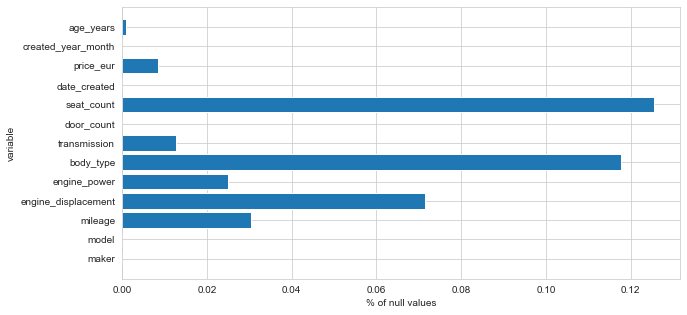

In [276]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

Input millage with mean in accordance to age of a car

In [277]:
df['mileage'] = df['mileage'].fillna(df.groupby(['age_years'])['mileage'].transform('mean'))

Impute engine_power, engine_displacement, seat_count and transmission with a mode for model and manufacture_year

In [278]:
vars = ['seat_count', 'transmission', 'engine_power', 'engine_displacement']
for i in vars:
    df[i] = df.groupby(['model'])[i].transform(lambda x: x.fillna(x.mode()))

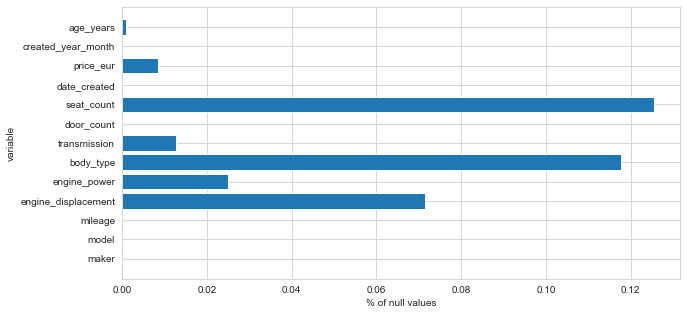

In [279]:
plt.figure(figsize=(10,5))
plt.barh(df.columns, width = df.isnull().sum()/len(df))
plt.xlabel('% of null values')
plt.ylabel('variable')
plt.show()

As we have reached serious imporovement can be reached, let's remove the records with missing values.

In [280]:
df.dropna(inplace=True)

By far the volume of the dataset is now some 40% of the initial dataset for specified period.

In [281]:
len(df), len(df)/raw_len

(709105, 0.398440300679552)

The cleaned dataset consists now of 709 105 cars, that is 39% of the initial file.

## Checking out the remaining variables

In [282]:
df['body_type'].value_counts(normalize=True)

other          0.983753
compact        0.007024
van            0.005085
convertible    0.001390
transporter    0.001382
coupe          0.001365
Name: body_type, dtype: float64

The category 'other' is prevailing over the body_type variable. The value of this variable is doubtful since 'other' includes most brands and models (SUV cars, truckts, as well as small compact cars). 

In [283]:
df[df['body_type']=='other'].head()

,maker,model,mileage,engine_displacement,engine_power,body_type,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
1260447,audi,q3,63933.0,1968.0,174.332872,other,auto,4.0,5.0,2016-01-16 01:34:02.783133+00,27990.0,2016_01,4.0
1260324,ford,transit,202600.0,1998.0,99.235635,other,man,4.0,9.0,2016-01-16 01:33:55.01396+00,2990.0,2016_01,15.0
1256544,toyota,yaris,14.0,1364.0,88.507458,other,man,5.0,5.0,2016-01-15 22:12:36.407341+00,13900.0,2016_01,1.0
1264644,mazda,cx-7,113916.0,2261.0,256.135219,other,man,4.0,5.0,2016-01-16 06:08:28.84931+00,9300.0,2016_01,8.0
1263957,hyundai,santa-fe,156559.0,2656.0,186.402070,other,man,5.0,5.0,2016-01-16 05:36:51.790394+00,5250.0,2016_01,9.0


In [284]:
df.drop(columns='body_type', inplace=True)

*************************

## Sampling the data frame to speed up modeling

<b> Before we go further with modeling I will make a sample of the dataset. This will speed up the learning process.

In [285]:
# original data size in volume and as % of raw dataframe.
len(df), len(df)/raw_len

(709105, 0.398440300679552)

In [286]:
df = df.sample(n=50000, random_state=random_seed).reset_index(drop=True)

In [287]:
len(df)

50000

In [288]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years
0,volkswagen,golf,11500.000000,1968.0,138.125275,man,2.0,4.0,2016-02-13 12:54:14.602503+00,20990.00,2016_02,1.0
1,skoda,fabia,148575.323746,1390.0,73.756215,man,5.0,5.0,2016-02-16 21:43:51.937924+00,1961.51,2016_02,11.0
2,volkswagen,golf-sportsvan,28000.000000,1598.0,108.622789,man,5.0,5.0,2016-02-11 08:17:57.837905+00,21500.00,2016_02,1.0
3,opel,astra,66500.000000,1364.0,138.125275,man,4.0,5.0,2016-03-06 02:04:52.879522+00,10364.54,2016_03,5.0
4,opel,agila,58278.000000,1200.0,84.484392,man,5.0,5.0,2016-02-18 21:17:21.843623+00,4800.00,2016_02,8.0


In [289]:
numeric_cols = ['price_eur' , 'age_years', 'mileage', 'engine_displacement', 'engine_power'] 

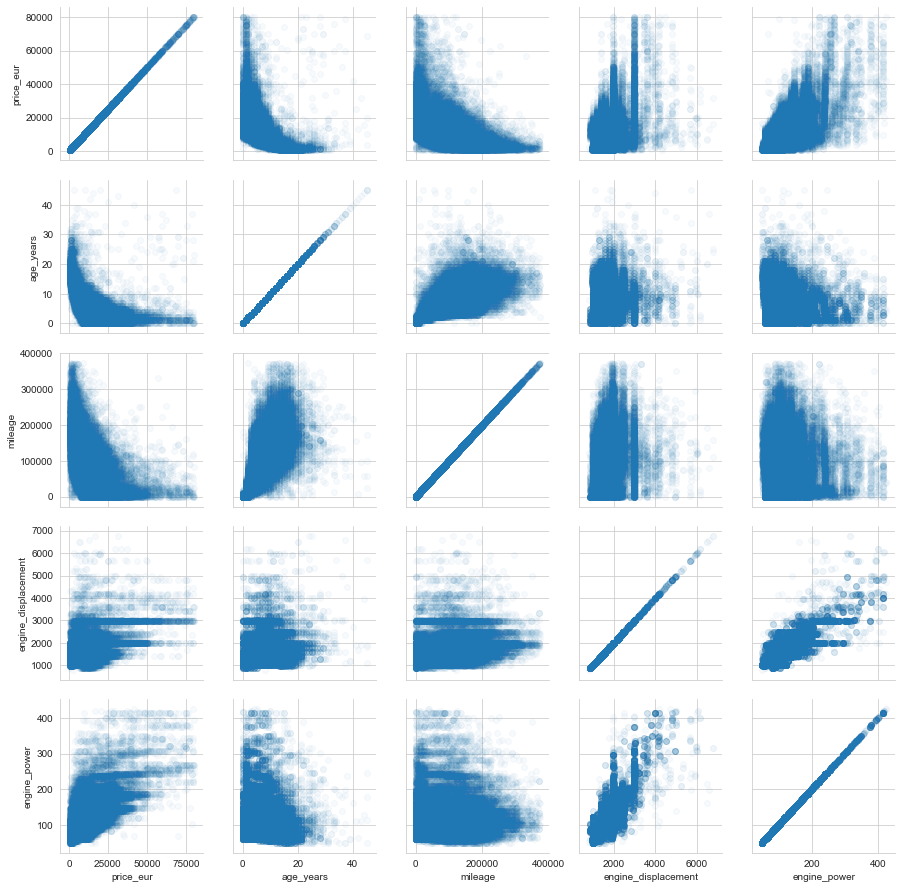

In [290]:
graph = sns.PairGrid(df[numeric_cols])
graph.map(plt.scatter, alpha=0.03)
plt.show()

Apart from engine_power vs. engine_displacement there is no clear linar correlation between metrics, especially when it comes to predict price for a car. 

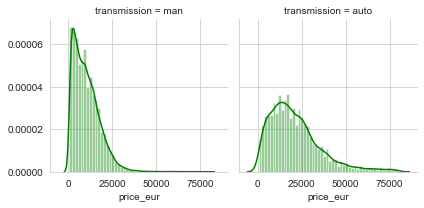

In [303]:
g = sns.FacetGrid(data=df,col='transmission')
g.map(sns.distplot, 'price_eur', color='green')
plt.show()

It seems that price distributions vs. transmission differ, so this variable will be included in modelling.

*************************

## Attempt to set up car segments by clustering

<b> Since we dropped much of categorical data in order predict car prices I will attempt to cluster cars into some homogenic groups. If the clustering will go fine, the clusters will be considered in furher price predictions, if not I will skip this step and go on with modeling section with no additional information about clusters.

Please note that due to manufacturer downsizing the same engine_displacement can result in completely different engine_power in accordance to age and make of a car.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [304]:
df['engine_power'][df['engine_displacement'].between(1490,1495)].describe()

count     63.000000
mean      93.126534
std       13.506725
min       67.051104
25%       80.461325
50%       95.212568
75%      107.281767
max      112.645855
Name: engine_power, dtype: float64

In [305]:
data_for_clustering = df[['engine_power', 'seat_count']]
data_for_clustering.head()

,engine_power,seat_count
0,138.125275,4.0
1,73.756215,5.0
2,108.622789,5.0
3,138.125275,5.0
4,84.484392,5.0


In [306]:
#MiniBatchClustering
data_clustered = StandardScaler().fit_transform(data_for_clustering)

clusters = range(2, 10)
silhouette = []
inertia  = []
for k in clusters:
    
    model = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=random_seed)
    
    model.fit(data_clustered)
    
    silhouette.append(silhouette_score(data_clustered, model.predict(data_clustered)))
    inertia.append(model.inertia_)

Plotting Silhouette and Inertia scores to set up optimal number of clusters

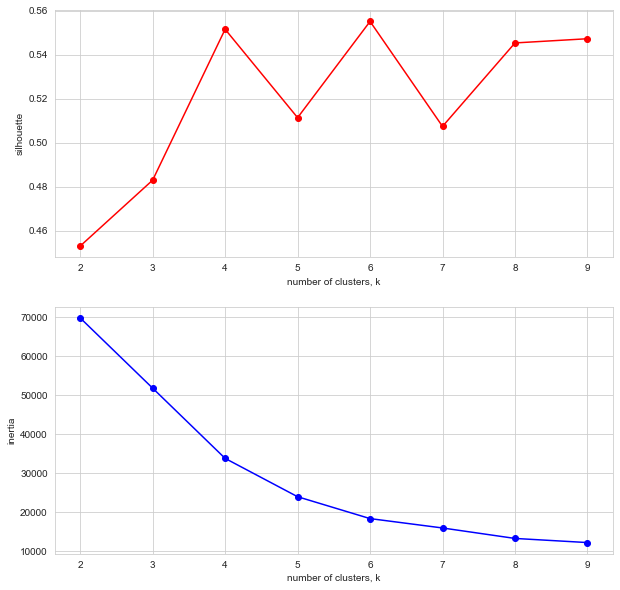

In [307]:
# Plot clusters vs silhouette
plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(clusters, silhouette, 'r-o', )
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette')

plt.subplot(2, 1, 2)
# Plot clusters vs silhouette
plt.plot(clusters, inertia, 'b-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')

plt.show()

The optimal values out of the specified cluster range is 6.

In [317]:
cluster_model = MiniBatchKMeans(n_clusters=6)
cluster_model.fit(data_clustered)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=6, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [318]:
df['cluster']=cluster_model.predict(data_clustered)

In [319]:
df.head()

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
0,volkswagen,golf,11500.000000,1968.0,138.125275,man,2.0,4.0,2016-02-13 12:54:14.602503+00,20990.00,2016_02,1.0,4
1,skoda,fabia,148575.323746,1390.0,73.756215,man,5.0,5.0,2016-02-16 21:43:51.937924+00,1961.51,2016_02,11.0,0
2,volkswagen,golf-sportsvan,28000.000000,1598.0,108.622789,man,5.0,5.0,2016-02-11 08:17:57.837905+00,21500.00,2016_02,1.0,0
3,opel,astra,66500.000000,1364.0,138.125275,man,4.0,5.0,2016-03-06 02:04:52.879522+00,10364.54,2016_03,5.0,5
4,opel,agila,58278.000000,1200.0,84.484392,man,5.0,5.0,2016-02-18 21:17:21.843623+00,4800.00,2016_02,8.0,0


In [320]:
df['cluster'].value_counts()

0    24239
5    13495
4     4962
2     3124
1     2327
3     1853
Name: cluster, dtype: int64

In [321]:
groups = df.groupby(by='cluster')['engine_power', 'door_count', 'seat_count', 'price_eur'].mean()

Check out how the cluster differ

AttributeError: type object 'set' has no attribute 'ylim'

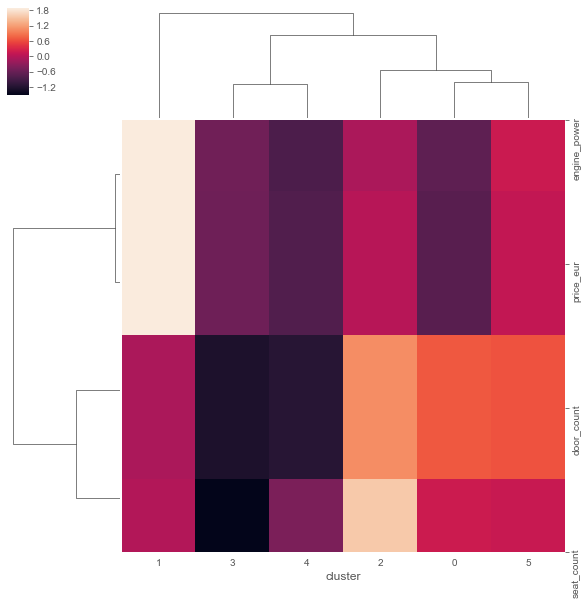

In [730]:
sns.clustermap(groups.T, z_score=0)
set.ylim(-0,5,0,5)

In [316]:
print(groups)

         engine_power  door_count  seat_count     price_eur
cluster                                                    
0           92.696776    4.316841    5.007441   8632.505686
1          153.184856    4.303527    4.938319  16443.156820
2          275.929258    3.857450    4.657364  32866.993491
3          136.916896    4.551536    7.187260  15678.305608
4          104.346290    3.154428    2.305616  10444.566523
5           83.313598    3.212573    3.999799   8353.189978


As we can see below one car model falls into several clusters, whis is not what we would like to accept, since prices are rather differentiated in accordance to models. Have a look ford mondeo, which falls into two clusters 5 and 0: 

In [338]:
df[(df['maker']=='ford') & (df['model']=='mondeo')]

,maker,model,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,date_created,price_eur,created_year_month,age_years,cluster
306,ford,mondeo,203000.000000,1798.0,123.374032,man,5.0,5.0,2016-02-25 15:48:13.124313+00,2499.00,2016_02,14.0,0
325,ford,mondeo,24050.000000,1997.0,177.014916,man,4.0,5.0,2016-03-08 12:33:53.322747+00,26989.00,2016_03,1.0,5
561,ford,mondeo,178115.379140,1800.0,88.507458,man,5.0,5.0,2016-02-10 19:55:22.375614+00,740.19,2016_02,17.0,0
594,ford,mondeo,168676.522586,1998.0,113.986878,man,4.0,5.0,2016-02-10 19:56:12.526297+00,1850.11,2016_02,14.0,0
875,ford,mondeo,63935.000000,1997.0,138.125275,auto,4.0,5.0,2016-03-03 17:43:24.701833+00,14257.70,2016_03,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49458,ford,mondeo,72009.000000,1997.0,138.125275,man,5.0,5.0,2016-02-20 03:20:36.776072+00,15780.00,2016_02,2.0,5
49513,ford,mondeo,236912.000000,1998.0,128.738121,man,5.0,5.0,2016-02-15 21:22:06.87144+00,990.00,2016_02,14.0,5
49659,ford,mondeo,120255.699360,1600.0,108.622789,man,5.0,5.0,2016-02-27 16:00:57.716236+00,6957.81,2016_02,8.0,0
49888,ford,mondeo,180000.000000,1998.0,113.986878,man,4.0,5.0,2016-03-10 08:25:47.426674+00,1999.00,2016_03,13.0,0


In [339]:
df.to_csv('.\Cars_sample_cleaned_50k.csv')

***************

# Modeling car prices

### Defining target variable and split dataset into training and testing set

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import  metrics

In [157]:
df = pd.read_csv('./Cars_sample_cleaned_50k.csv', sep=',', low_memory=False, index_col=[0])
#df = df.iloc[:100]

In [158]:
df.columns

Index(['maker', 'model', 'mileage', 'engine_displacement', 'engine_power',
       'transmission', 'door_count', 'seat_count', 'date_created', 'price_eur',
       'created_year_month', 'age_years', 'cluster'],
      dtype='object')

In [159]:
df.dtypes

maker                   object
model                   object
mileage                float64
engine_displacement    float64
engine_power           float64
transmission            object
door_count             float64
seat_count             float64
date_created            object
price_eur              float64
created_year_month      object
age_years              float64
cluster                  int64
dtype: object

In [160]:
df['transmission'].value_counts()

man     39523
auto    10477
Name: transmission, dtype: int64

In [161]:
df['transmission'] = df['transmission'].apply(lambda x: 0 if (x=='man') else 1) 

In [162]:
cat_variables = ['door_count', 'seat_count', 'cluster']

for i in cat_variables:
    df[i] = df[i].astype('category')

# df['door_count'] = df['door_count'].astype('category')
# df['door_count'] = df['door_count'].astype('category')
# df['seat_count'] = df['seat_count'].astype('category')
# df['cluster'] = df['cluster'].astype('category')

In [163]:
# df['transmission'] = df['transmission'].astype('category')
# # df['door_count'] = df['door_count'].astype(int).astype(str)
# df['seat_count'] = df['seat_count'].astype(int).astype(str)
# df['cluster'] = df['cluster'].astype(int).astype(str)

In [164]:
y = df['price_eur']
X = df.drop(['maker', 'model', 'price_eur', 'date_created', 'created_year_month'], axis=1)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [166]:
X.head()

,mileage,engine_displacement,engine_power,transmission,door_count,seat_count,age_years,cluster
0,11500.000000,1968.0,138.125275,0,2.0,4.0,1.0,4
1,148575.323746,1390.0,73.756215,0,5.0,5.0,11.0,0
2,28000.000000,1598.0,108.622789,0,5.0,5.0,1.0,0
3,66500.000000,1364.0,138.125275,0,4.0,5.0,5.0,5
4,58278.000000,1200.0,84.484392,0,5.0,5.0,8.0,0


### Setting up kfold cross-validation criteria:

In [167]:
kfold = model_selection.KFold(n_splits=5, random_state=random_seed)

### Specify pipeline

In [168]:
# Create the preprocessing pipelines for both numeric and categorical data, and separately for eahc type.
numeric_features = ['mileage', 'engine_displacement','engine_power', 'age_years']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['door_count', 'seat_count', 'cluster']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

num_preprocessor_only = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])

cat_preprocessor_only = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])


##  Linear regression

In [169]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4]}

lm_1 = GridSearchCV(
    make_pipeline(cat_preprocessor_only, 
                  PolynomialFeatures(degree=2), 
                  linear_model.LinearRegression()),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_1.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('cat',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('onehot',
                                                                                          OneHotEncoder(categories='auto',
                                                                                        

In [170]:
print(lm_1.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_1.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_1.predict(X_test)))

{'polynomialfeatures__degree': 2} 
R2: 0.3310335425747126 
MAE: 6230.9445975879935


## Linear regression - ridge regularization 

In [ ]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000, 10000]}

lm_2_rr = GridSearchCV(
    make_pipeline(cat_preprocessor_only, 
                  PolynomialFeatures(degree=2), 
                  linear_model.Ridge(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_2_rr.fit(X_train, y_train)

In [ ]:
print(lm_2_rr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_2_rr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_2_rr.predict(X_test)))

## Linear Regression - lasso regularization

In [ ]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lm_3_lr = GridSearchCV(
    make_pipeline(
        cat_preprocessor_only, 
        PolynomialFeatures(degree=2), linear_model.Lasso(random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_3_lr.fit(X_train, y_train)

In [ ]:
print(lm_3_lr.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_3_lr.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_3_lr.predict(X_test)))

## Linear regression - elasticnet regularization

In [ ]:
param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lm_4_en = GridSearchCV(
    make_pipeline(
        cat_preprocessor_only, 
        PolynomialFeatures(degree=2), ElasticNet(alpha=1, random_state=random_seed)),
    param_grid=param_grid,
    cv=kfold,
    refit=True, 
    n_jobs=-1)

lm_4_en.fit(X_train, y_train)

In [ ]:
print(lm_4_en.best_params_, 
      '\nR2:', metrics.r2_score(y_test, lm_4_en.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, lm_4_en.predict(X_test)))

## Support Vector Regression

In [ ]:
pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), ('SVR', SVR(kernel='rbf'))])

param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only)],
              'SVR__gamma': [0.001], #0.01, 0.1, 1, 10, 100
              'SVR__C': [1]} #10, 100,1000,10000, 20000

svr_5 = GridSearchCV(pipe, 
                     param_grid, 
                     cv=kfold, 
                     return_train_score=True, 
                     n_jobs=-1)

svr_5.fit(X_train, y_train)

In [ ]:
# Old.
# param_grid = {'preprocessing': [StandardScaler(), None],
#               'SVM_Reg__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'SVM_Reg__C': [1, 10, 100,1000,10000, 20000]}

# svr_5 = GridSearchCV(param_grid, cv=kfold, return_train_score=True)

# svr_5.fit(X_train, y_train)

In [ ]:
print(svr_5.best_params_, 
      '\nR2:', metrics.r2_score(y_test, svr_5.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, svr_5.predict(X_test)))

# Random forest regression

In [ ]:
param_grid = {'n_estimators': [20, 50, 100, 200, 500, 1000],
              'max_depth':  [20, 50, 100, 200],  
              'max_features': ['log2','sqrt','auto'],
              'max_leaf_nodes':  [100, 200, 300]}

rfr = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=50, 
                            oob_score = True, random_state=random_seed)
                 
rfr_6 = GridSearchCV(rfr,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

rfr_6.fit(X_train, y_train)

In [ ]:
# pipe = Pipeline([('preprocessing', make_pipeline(cat_preprocessor_only)), 
#                  ('RFR', RandomForestRegressor(n_jobs=-1, max_features= 'sqrt', n_estimators=50, 
#                                        oob_score = True, random_state=random_seed))])

# param_grid = {'RFR__n_estimators': [20], #50, 100, 200, 500, 1000
#               'RFR__max_depth':  [20], # 50, 100, 200
#               'RFR__max_features': ['log2'], # 'sqrt','auto'
#               'RFR__max_leaf_nodes':  [100, 200, 300]}

# rfr_6 = GridSearchCV(pipe,
#                      param_grid=param_grid,
#                      cv=kfold, n_jobs=-1)

# rfr_6.fit(X_train, y_train)

In [ ]:
print(rfr_6.best_params_, 
      '\nR2:', metrics.r2_score(y_test, rfr_6.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, rfr_6.predict(X_test)))

Printing out feature importances for RFR model:

In [ ]:
feat_importances = pd.Series(data=rfr_6.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=True)

In [ ]:
feat_importances.index

In [ ]:
plt.barh(feat_importances.index, feat_importances.values, color='green')
plt.show()

In [ ]:
plt.barh(feat_importances.index, feat_importances.values.cumsum())
plt.show()

The most important features to predict car prices is age power, engine_displacement and mileage. The remaining predictors are of minor imporance.

## Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = Pipeline([('preprocessing', make_pipeline(full_preprocessor)), 
                 ('GBR', GradientBoostingRegressor(loss='ls', n_estimators=50, random_state=random_seed))])

param_grid = {'preprocessing': [make_pipeline(full_preprocessor), make_pipeline(cat_preprocessor_only), None],
              'GBR__n_estimators': [10, 20, 50] # 100, 200, 500
             }


gbr_7 = GridSearchCV(pipe,
                     param_grid=param_grid,
                     cv=kfold, 
                     n_jobs=-1)

gbr_7.fit(X_train, y_train)

In [ ]:
print(gbr_7.best_params_, 
      '\nR2:', metrics.r2_score(y_test, gbr_7.predict(X_test)), 
      '\nMAE:', metrics.mean_absolute_error(y_test, gbr_7.predict(X_test)))

# Model Comparison Summary

In [ ]:
models = []
models.append(('Linear Regression', lm_1.best_estimator_))
models.append(('Ridge', lm_2_rr.best_estimator_))
models.append(('Lasso', lm_3_lr.best_estimator_))
models.append(('ElasticNet', lm_4_en.best_estimator_))
models.append(('Support Vector Regressor', svr_5.best_estimator_))
models.append(('Random Forrest Regressor', rfr_6.best_estimator_))
models.append(('Gradient Boosting Regressor', gbr_7.best_estimator_))

r2 = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Mean absolute error: {}".format( metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
    print("------------------------------------------")

In [ ]:
d = {'R2': r2, 
     'MAE': mean_absolute_error}
df_models = pd.DataFrame(data=d)
df_models.insert(loc=0, column='Method', value=['Linear Regression', 
                                         'Ridge',
                                         'Lasso', 
                                         'ElasticNet',
                                         'Support Vector Regressor',
                                         'Random Forrest Regressor',
                                         'Gradient Boosting Regressor'])
df_models.set_index('Method', inplace=True)

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5))
plt.subplot(121)
df_models['R2'].plot(kind='bar', color='blue')
plt.ylabel('R2')

plt.subplot(122)
df_models['MAE'].plot(kind='bar', color='green')
plt.xlabel('Method')
plt.ylabel('MAE')
plt.show()

By far Random forest algorithm brought out 93% R2 score, which is far better than of the bul of  Linear Regression models, but still MAE is quite big (2,5 k EUR on Average). Can we go better?

# Project conclusion

<b> On the 50 000 car dataset that was sampled from cleaned dataset I managed to reach: 

Random forrest regressor proved to be best algorithm out of the methods checked.

It is still not perfect, but it is more than I expected. After cleaning the dataset, just before starting to create first models, I was a bit anxious how my modelling will perform. Real data is far more challenging than ordinary, ready-to-used datasets that I got used to during my bootcamp clasesss.
    
There is still a place to improve by tunning models or checking out neural networks. This will be performed as a supplement to this project later on.